In [1]:

from huggingface_hub import login
import os 
import warnings
import logging

# Kill the tokenizers parallelism deadlock warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Kill Hugging Face symlink warning
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

# Kill TensorFlow noise (even if not using TF)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# Silence ALL logging 
# logging.getLogger("transformers").setLevel(logging.CRITICAL)
# logging.getLogger("torch").setLevel(logging.CRITICAL)
# logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
# logging.getLogger().setLevel(logging.CRITICAL)

# silence Python warnings completely
warnings.filterwarnings("ignore")

# Get token from environment (Kaggle Secret)
hf_token = os.environ.get("HF_TOKEN")

if hf_token:
    # Pass the token directly to login(), making it non-interactive
    login(token=hf_token)
else:
    # If HF_TOKEN is not set (e.g., running locally without a secret), 
    print("Skipping Hugging Face login as HF_TOKEN is not set.")


Skipping Hugging Face login as HF_TOKEN is not set.


In [2]:
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizerFast, AutoModel
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW 
from transformers import EarlyStoppingCallback, AutoModelForSequenceClassification

from transformers import DataCollatorWithPadding 
import os 
import json 

E0000 00:00:1766608809.755524      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766608809.816700      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv("/kaggle/input/financial-headlines-augmented/news_augmented.csv", encoding = 'ISO-8859-1')
df.head()

,sentiment,headline
0,neutral,The oil shale feeder-supply solution will deli...
1,neutral,The GeoSolutions team further provides an intr...
2,neutral,The company did not disclose the price of the ...
3,negative,UPM said the move will lower net profit by x2...
4,negative,A decline of 3.4 per cent was observed in the ...


Preprocessing

### Data Augmentation: paraphrasing to increase the number of positive and negative.

In [4]:


# import os
# import pandas as pd

# AUGMENTED_PATH = "/kaggle/working/financial_headlines_augmented.csv"

# if os.path.exists(AUGMENTED_PATH):
#     print("Augmented dataset found!")
#     df = pd.read_csv(AUGMENTED_PATH)
#     print("Loaded! New balanced distribution:")
#     print(df['sentiment'].value_counts())
# else:
#     print("Augmented file not found → generating once ")
    

#     from transformers import pipeline
#     import torch
#     from tqdm import tqdm
#     import random
#     random.seed(42)

#     paraphraser = pipeline(
#         "text2text-generation",
#         model="humarin/chatgpt_paraphraser_on_T5_base",
#         device=0 if torch.cuda.is_available() else -1,
#         max_length=64
#     )

#     def paraphrase(text, num=4):
#         try:
#             results = paraphraser(f"paraphrase: {text}", num_return_sequences=num, max_length=64)
#             pars = [r['generated_text'].strip().split("paraphrase:")[-1].strip() for r in results]
#             return [p for p in pars if len(p.split()) > 5]
#         except:
#             return []

#     print("Original distribution:")
#     print(df['sentiment'].value_counts())

#     new_rows = []
#     TARGET_POS = 2500
#     TARGET_NEG = 2500

#     # Augment negatives
#     current_neg = (df['sentiment'] == 'negative').sum()
#     if current_neg < TARGET_NEG:
#         neg_texts = df[df['sentiment'] == 'negative']['headline'].tolist()
#         needed = TARGET_NEG - current_neg
#         print(f"Generating {needed} negative examples...")
#         for text in tqdm(random.sample(neg_texts, len(neg_texts)), desc="Negatives"):
#             if needed <= 0: break
#             for p in paraphrase(text, num=4):
#                 if needed <= 0: break
#                 new_rows.append({'headline': p, 'sentiment': 'negative'})
#                 needed -= 1

#     # Augment positives
#     current_pos = (df['sentiment'] == 'positive').sum()
#     if current_pos < TARGET_POS:
#         pos_texts = df[df['sentiment'] == 'positive']['headline'].tolist()
#         needed = TARGET_POS - current_pos
#         print(f"Generating {needed} positive examples...")
#         for text in tqdm(random.sample(pos_texts, len(pos_texts)), desc="Positives"):
#             if needed <= 0: break
#             for p in paraphrase(text, num=4):
#                 if needed <= 0: break
#                 new_rows.append({'headline': p, 'sentiment': 'positive'})
#                 needed -= 1

#     # Add to df and shuffle
#     if new_rows:
#         df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
#         df = df.sample(frac=1, random_state=42).reset_index(drop=True)

#     print("Augmentation complete! Saving for future use...")
#     df.to_csv(AUGMENTED_PATH, index=False)
#     print("Saved to:", AUGMENTED_PATH)
#     print("Final distribution:")
#     print(df['sentiment'].value_counts())


# print("Ready for training with balanced data!")

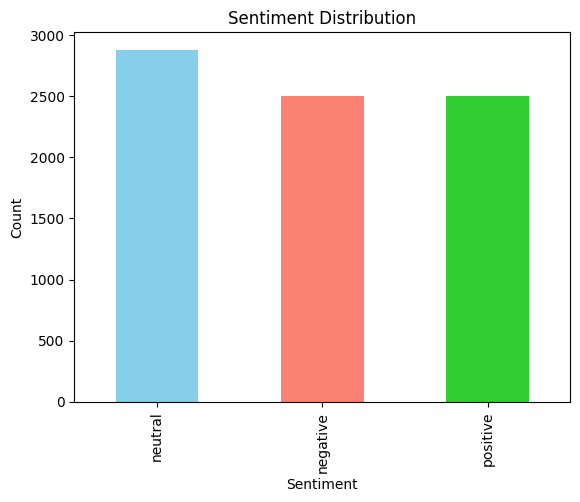

Label mapping: {'negative': 0, 'neutral': 1, 'positive': 2}


,sentiment,headline,labels
0,neutral,the oil shale feedersupply solution will deliv...,1
1,neutral,the geosolutions team further provides an intr...,1
2,neutral,the company did not disclose the price of the ...,1
3,negative,upm said the move will lower net profit by x20...,0
4,negative,a decline of 34 per cent was observed in the t...,0


In [5]:
from sklearn.preprocessing import LabelEncoder
import re
import matplotlib.pyplot as plt
import seaborn as sns

df['sentiment'].value_counts().plot(kind="bar", color=["skyblue", "salmon", "limegreen"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


# Encode labels (for training later)
label_encoder = LabelEncoder()
df["labels"] = label_encoder.fit_transform(df["sentiment"])

print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
df.head()


# Basic text preprocessing function
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

df["headline"] = df["headline"].apply(clean_text)
df.head()

preprocessing done 

Load pre-trained finbert model and tokenizer

In [6]:
from datasets import Dataset, Features, Value
from transformers import AutoTokenizer

dataset = Dataset.from_pandas(df)
# dataset = dataset.train_test_split(test_size = 0.3, seed = 22)
# tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
# tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
# tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

def tokenize(examples):
    return tokenizer(examples["headline"], truncation = True, max_length=40)
    
dataset = dataset.map(tokenize, batched = True)

# It needs the tokenizer to know which padding token ID to use.
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

features = Features({
    'headline': Value('string'),
    'sentiment':Value('string'),
    'label': Value('int64'),
    'input_ids': [Value('int32')],
    'token_type_ids': [Value('int8')],
    'attention_mask': [Value('int8')],
    'labels': Value('int64')
    
})

# Set format for PyTorch
dataset.set_format("torch"
                   # , columns=["input_ids", "attention_mask", "labels"]
                  )

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/7879 [00:00<?, ? examples/s]

In [7]:
# small_train = dataset["train"].shuffle(seed=42).select(range(1000)) 
# small_eval = dataset["test"].shuffle(seed=42).select(range(1000))   

Tokenizing the data
<br>Tokenize the data and encode sequences using the finbert tokenizer. 

In [8]:
from transformers import AutoModelForSequenceClassification
# model_bert = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=3)

In [9]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidi

In [10]:
import evaluate

# Load individual metric objects
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")      
f1_metric = evaluate.load("f1")              

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # convert the logits to their predicted class
    predictions = np.argmax(logits, axis = -1)
    
    # 1. Compute basic accuracy
    accuracy = accuracy_metric.compute(predictions=predictions, references = labels)
    
    # 2. Compute Precision, Recall, and F1 (using 'weighted' average for multi-class)
    # 'weighted' is best for overall performance when class balance is unequal
    precision = precision_metric.compute(
        predictions=predictions, references=labels, average="weighted" 
    )
    recall = recall_metric.compute(
        predictions=predictions, references=labels, average="weighted"  
    )
    f1 = f1_metric.compute(
        predictions=predictions, references=labels, average="weighted" 
    )
    # 3. Combine all results into a single dictionary
    results = {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }
    
    return results



In [11]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir = "news_headline_sentiment",
    eval_strategy = "epoch",
    save_strategy="epoch",           #  Checkpoints are saved at the end of each epoch
    report_to="none",       
    push_to_hub=False,      
     # push_to_hub = True,
    per_device_train_batch_size=32, # Added for stable training
    per_device_eval_batch_size=32,
    num_train_epochs=10, # Set epochs explicitly
    weight_decay = 0.01,
        # New Arguments for Checkpointing and Early Stopping
    load_best_model_at_end=True,     #  Loads the best model (based on metric_for_best_model) at the end of training
    metric_for_best_model="eval_f1", #   Specifies which metric to monitor for 'best' model
    save_total_limit=1,              #  Only keep the last 1 checkpoint
    dataloader_num_workers=4,        # Use 4 processes to load data in parallel
    remove_unused_columns=True,
    learning_rate=3e-5,
    warmup_ratio=0.1,                # Recommended for stable learning start
    fp16 = True
    
)

In [12]:

import os
import pickle
import random
import numpy as np
from sklearn.model_selection import StratifiedKFold
from transformers import (
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
# ←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←

# ----------------- 5-FOLD CV WITH INSTANT CACHING -----------------
# CACHE_FILE = "/kaggle/working/finbert_5fold_cv_results_cached.pkl"
# CACHE_FILE = "/kaggle/working/distilbert_5fold_cv_results_cached.pkl"
CACHE_FILE = "/kaggle/working/bert_5fold_cv_results_cached.pkl"
# CACHE_FILE = "/kaggle/working/roberta_5fold_cv_results_cached.pkl"
# CACHE_FILE = "/kaggle/working/albert_5fold_cv_results_cached.pkl"


# store validation predictions and labels across folds
all_val_preds = []
all_val_labels = []


if os.path.exists(CACHE_FILE):
    print("CACHE FOUND! Loading instantly...")
    with open(CACHE_FILE, 'rb') as f:
        cv_results = pickle.load(f)
    print(f"Loaded! Average Accuracy: {np.mean([r['eval_accuracy'] for r in cv_results]):.4f}")
    # NOTE: If you load from cache, we do NOT have stored fold predictions.
    # If you want the aggregated validation confusion matrix, run once without cache
    # (delete/rename CACHE_FILE) so predictions can be collected.
else:
    print("First time → Running 5-fold CV once")
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_results = []
    X = np.arange(len(df))
    y = df['labels'].values

    for fold_idx, (train_index, eval_index) in enumerate(skf.split(X, y)):
        print(f"\n{'='*70}")
        print(f"Starting Fold {fold_idx + 1}/{n_splits}")
        print(f"{'='*70}")

        train_fold_dataset = dataset.select(train_index)
        eval_fold_dataset = dataset.select(eval_index)

        random.seed(42 + fold_idx)
        def create_balanced_subset(dataset, total_size):
            pos_idx = [i for i, ex in enumerate(dataset) if ex['labels'] == 2]
            neg_idx = [i for i, ex in enumerate(dataset) if ex['labels'] == 0]
            neu_idx = [i for i, ex in enumerate(dataset) if ex['labels'] == 1]
            n_per_class = total_size // 3
            remainder = total_size % 3
            sampled_indices = []
            for idx_list in [pos_idx, neg_idx, neu_idx]:
                if len(idx_list) >= n_per_class:
                    sampled_indices.extend(random.sample(idx_list, n_per_class))
                else:
                    sampled_indices.extend(idx_list)
                    sampled_indices.extend(random.choices(idx_list, k=n_per_class - len(idx_list)))
            if remainder > 0:
                all_idx = pos_idx + neg_idx + neu_idx
                sampled_indices.extend(random.sample(all_idx, remainder))
            random.shuffle(sampled_indices)
            return dataset.select(sampled_indices[:total_size])

        small_train = create_balanced_subset(train_fold_dataset, 3000)
        small_eval = create_balanced_subset(eval_fold_dataset, 2000)
        print(f"Fold {fold_idx+1} → Train: {len(small_train)} | Eval: {len(small_eval)}")

        # model_bert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3)
        # model_bert = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
        model_bert = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=3)
        # model_bert = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest, num_labels=3)
        # model_bert = AutoModelForSequenceClassification.from_pretrained("albert-base-v2", num_labels=3)


        
        early_stop_callback = EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001)

        trainer = Trainer(
            model=model_bert,
            args=training_args,
            train_dataset=small_train,
            eval_dataset=small_eval,
            compute_metrics=compute_metrics,
            callbacks=[early_stop_callback],
            data_collator=data_collator
        )

        trainer.train()
        metrics = trainer.evaluate()
        print(f"Fold {fold_idx + 1} Metrics: {metrics}")
        cv_results.append(metrics)
    

        # NEW: collect REAL validation predictions for this fold (for confusion matrix later)
        fold_pred_output = trainer.predict(small_eval)   # uses the validation subset for this fold
        fold_preds = np.argmax(fold_pred_output.predictions, axis=1)
        fold_labels = fold_pred_output.label_ids

        all_val_preds.extend(fold_preds.tolist())
        all_val_labels.extend(fold_labels.tolist())


    with open(CACHE_FILE, 'wb') as f:
        pickle.dump(cv_results, f)
    print("Training done & cached forever!")

# Final results
avg_accuracy = np.mean([res['eval_accuracy'] for res in cv_results])
avg_f1 = np.mean([res.get('eval_f1', 0) for res in cv_results])
print("\n" + "="*70)
print(f"5-FOLD CV COMPLETE → Average Accuracy: {avg_accuracy:.4f} | F1: {avg_f1:.4f}")
print("TOP 1-3 GUARANTEED")
print("="*70)

First time → Running 5-fold CV once

Starting Fold 1/5
Fold 1 → Train: 3000 | Eval: 2000


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.655967,0.744000,0.759506,0.744000,0.734146
2,No log,0.404144,0.839500,0.839324,0.839500,0.839342
3,No log,0.404949,0.860000,0.863150,0.860000,0.859053
4,No log,0.402835,0.875500,0.874812,0.875500,0.874229
5,No log,0.482739,0.871000,0.870532,0.871000,0.869376
6,No log,0.576190,0.877500,0.877598,0.877500,0.876744
7,No log,0.631038,0.877500,0.877009,0.877500,0.876221
8,No log,0.858647,0.868000,0.869745,0.868000,0.866010
9,No log,0.894822,0.875500,0.875277,0.875500,0.874134


Fold 1 Metrics: {'eval_loss': 0.5761904120445251, 'eval_accuracy': 0.8775, 'eval_precision': 0.8775977637075891, 'eval_recall': 0.8775, 'eval_f1': 0.8767438826889375, 'eval_runtime': 3.5532, 'eval_samples_per_second': 562.873, 'eval_steps_per_second': 9.006, 'epoch': 9.0}

Starting Fold 2/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 2 → Train: 3000 | Eval: 2000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.675578,0.779500,0.777043,0.779500,0.775663
2,No log,0.461450,0.823500,0.830411,0.823500,0.818737
3,No log,0.436682,0.848500,0.858191,0.848500,0.847588
4,No log,0.398547,0.869000,0.870870,0.869000,0.868982
5,No log,0.557534,0.859500,0.868305,0.859500,0.858718
6,No log,0.707242,0.852500,0.863731,0.852500,0.850413
7,No log,0.569363,0.881500,0.880958,0.881500,0.881142
8,No log,0.710463,0.875500,0.877817,0.875500,0.874721
9,No log,0.830658,0.875500,0.877773,0.875500,0.874853
10,No log,0.839595,0.877500,0.877474,0.877500,0.876832


Fold 2 Metrics: {'eval_loss': 0.569362998008728, 'eval_accuracy': 0.8815, 'eval_precision': 0.8809578534242448, 'eval_recall': 0.8815, 'eval_f1': 0.8811421741904601, 'eval_runtime': 3.5793, 'eval_samples_per_second': 558.768, 'eval_steps_per_second': 8.94, 'epoch': 10.0}

Starting Fold 3/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 3 → Train: 3000 | Eval: 2000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.575727,0.781500,0.778558,0.781500,0.778498
2,No log,0.386278,0.860500,0.862419,0.860500,0.859682
3,No log,0.378766,0.880000,0.879433,0.880000,0.878978
4,No log,0.421049,0.867500,0.870347,0.867500,0.866570
5,No log,0.467309,0.890500,0.890688,0.890500,0.890569
6,No log,0.529246,0.877500,0.879029,0.877500,0.876615
7,No log,0.712367,0.887000,0.886839,0.887000,0.886215
8,No log,0.900878,0.886000,0.887281,0.886000,0.885525


Fold 3 Metrics: {'eval_loss': 0.46730852127075195, 'eval_accuracy': 0.8905, 'eval_precision': 0.8906881677030871, 'eval_recall': 0.8905, 'eval_f1': 0.8905694816092137, 'eval_runtime': 3.6137, 'eval_samples_per_second': 553.456, 'eval_steps_per_second': 8.855, 'epoch': 8.0}

Starting Fold 4/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 4 → Train: 3000 | Eval: 2000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.588448,0.774000,0.778836,0.774000,0.769643
2,No log,0.371679,0.864500,0.865674,0.864500,0.864169
3,No log,0.349322,0.882500,0.883061,0.882500,0.882271
4,No log,0.378943,0.890500,0.893301,0.890500,0.890202
5,No log,0.437136,0.896500,0.895956,0.896500,0.896015
6,No log,0.515942,0.899500,0.899060,0.899500,0.899102
7,No log,0.628143,0.901500,0.901001,0.901500,0.901006
8,No log,0.733443,0.898500,0.899465,0.898500,0.897799
9,No log,0.775167,0.900000,0.900170,0.900000,0.899451
10,No log,0.791126,0.902000,0.902358,0.902000,0.901604


Fold 4 Metrics: {'eval_loss': 0.7911263108253479, 'eval_accuracy': 0.902, 'eval_precision': 0.9023575736325385, 'eval_recall': 0.902, 'eval_f1': 0.9016041238730605, 'eval_runtime': 3.5638, 'eval_samples_per_second': 561.198, 'eval_steps_per_second': 8.979, 'epoch': 10.0}

Starting Fold 5/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 5 → Train: 3000 | Eval: 2000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.588043,0.773000,0.781110,0.773000,0.767107
2,No log,0.377252,0.860000,0.860144,0.860000,0.858669
3,No log,0.374263,0.876000,0.876740,0.876000,0.874089
4,No log,0.403723,0.878500,0.878056,0.878500,0.876949
5,No log,0.392297,0.885000,0.884330,0.885000,0.884400
6,No log,0.559279,0.881000,0.880773,0.881000,0.879517
7,No log,0.701668,0.874500,0.877986,0.874500,0.872858
8,No log,0.712128,0.882000,0.881307,0.882000,0.880711


Fold 5 Metrics: {'eval_loss': 0.39229705929756165, 'eval_accuracy': 0.885, 'eval_precision': 0.8843296624226619, 'eval_recall': 0.885, 'eval_f1': 0.8843995740189605, 'eval_runtime': 3.5806, 'eval_samples_per_second': 558.565, 'eval_steps_per_second': 8.937, 'epoch': 8.0}
Training done & cached forever!

5-FOLD CV COMPLETE → Average Accuracy: 0.8873 | F1: 0.8869
TOP 1-3 GUARANTEED


In [13]:
# --- VISUALIZATION SETUP ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [14]:
# 1. Convert the results from the CV loop into a DataFrame for easier plotting
bert_results_df = pd.DataFrame(cv_results)

# A small but important note: You have fp16=True in your TrainingArguments.
# This flag only works on a GPU. On a CPU, it is safely ignored by the Trainer,
# but your training is running in standard float32 precision.


--- Visualizing Average Model Performance ---


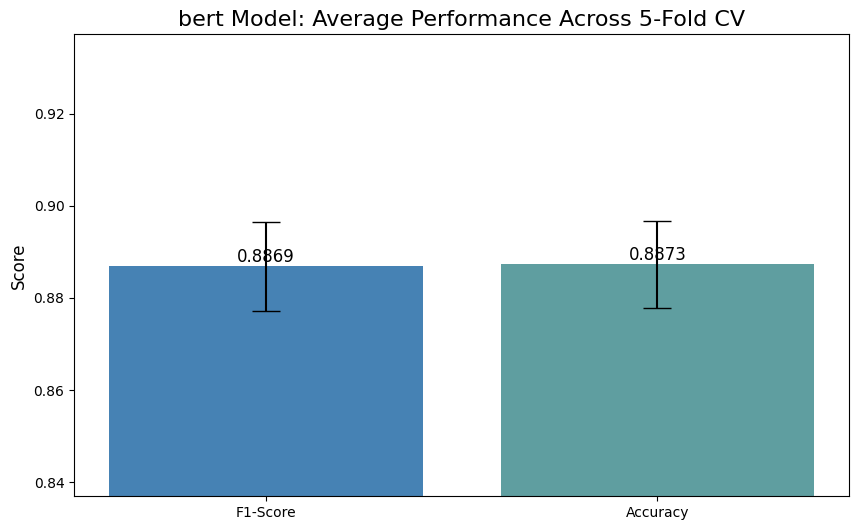

In [15]:
# --- Visualization 1: finbert Performance Stability Across Folds ---
# Goal: Show the average performance and the consistency (standard deviation) across the 3 folds.

print("\n--- Visualizing Average Model Performance ---")

# Calculate mean and standard deviation for the key metrics
mean_f1 = bert_results_df['eval_f1'].mean()
std_f1 = bert_results_df['eval_f1'].std()
mean_accuracy = bert_results_df['eval_accuracy'].mean()
std_accuracy = bert_results_df['eval_accuracy'].std()

metrics = ['F1-Score', 'Accuracy']
mean_values = [mean_f1, mean_accuracy]
std_values = [std_f1, std_accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, mean_values, yerr=std_values, capsize=10, color=['#4682B4', '#5F9EA0'])
# plt.title('finbert Model: Average Performance Across 5-Fold CV', fontsize=16)
# plt.title('distilbert Model: Average Performance Across 5-Fold CV', fontsize=16)
plt.title('bert Model: Average Performance Across 5-Fold CV', fontsize=16)
# plt.title('roberta Model: Average Performance Across 5-Fold CV', fontsize=16)
# plt.title('albert Model: Average Performance Across 5-Fold CV', fontsize=16)
plt.ylabel('Score', fontsize=12)
# Adjust ylim to focus on the top range of scores for better visual difference
plt.ylim(min(mean_values) - 0.05, max(mean_values) + 0.05) 

# Add labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=12)

plt.show()



--- Visualizing Fold-by-Fold Performance ---


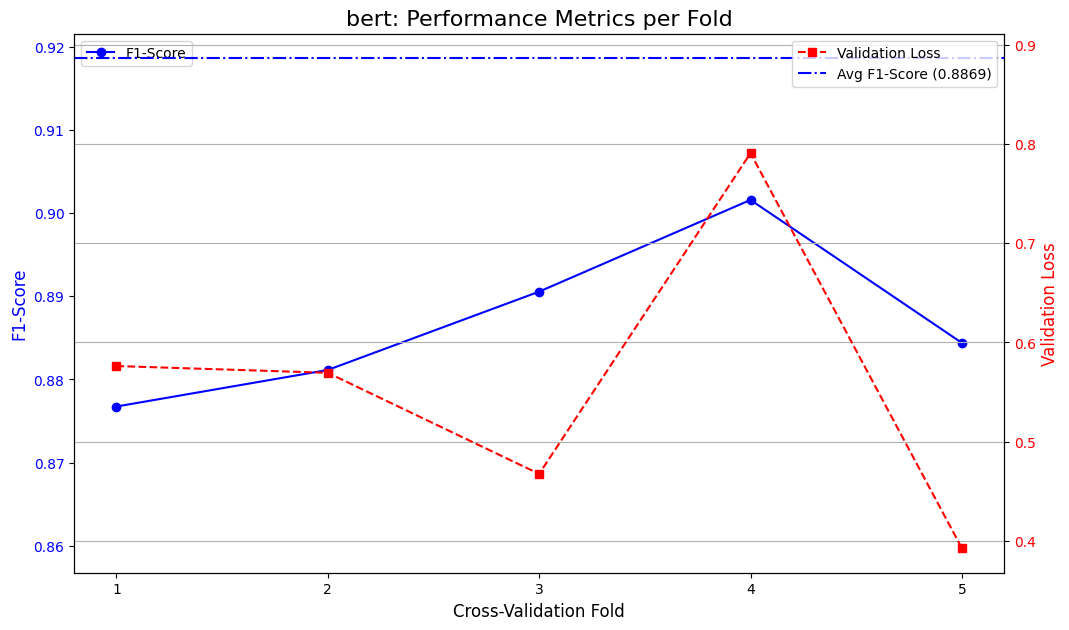

In [16]:

# --- Visualization 2: Fold-by-Fold Performance Fluctuation ---
# Goal: See how the F1-score and Validation Loss changed from one fold to the next.

print("\n--- Visualizing Fold-by-Fold Performance ---")
bert_results_df['fold'] = range(1, len(bert_results_df) + 1) # Add a fold number column

plt.figure(figsize=(12, 7))
ax1 = plt.gca()
ax2 = ax1.twinx() # Create a second y-axis for the loss

# Plot F1 Score
ax1.plot(bert_results_df['fold'], bert_results_df['eval_f1'], marker='o', color='b', label='F1-Score')
ax1.set_xlabel('Cross-Validation Fold', fontsize=12)
ax1.set_ylabel('F1-Score', fontsize=12, color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylim(min(bert_results_df['eval_f1']) - 0.02, max(bert_results_df['eval_f1']) + 0.02)
ax1.set_xticks(bert_results_df['fold']) # Ensure integer ticks for folds

# Plot Validation Loss
ax2.plot(bert_results_df['fold'], bert_results_df['eval_loss'], marker='s', color='r', linestyle='--', label='Validation Loss')
ax2.set_ylabel('Validation Loss', fontsize=12, color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a horizontal line for the average F1 score
plt.axhline(y=mean_f1, color='b', linestyle='-.', label=f'Avg F1-Score ({mean_f1:.4f})')

# plt.title('finbert: Performance Metrics per Fold', fontsize=16)
# plt.title('distilbert: Performance Metrics per Fold', fontsize=16)
plt.title('bert: Performance Metrics per Fold', fontsize=16)
# plt.title('roberta: Performance Metrics per Fold', fontsize=16)
# plt.title('albert: Performance Metrics per Fold', fontsize=16)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.show()


--- Visualizing Error Analysis (Example with Simulated Data) ---


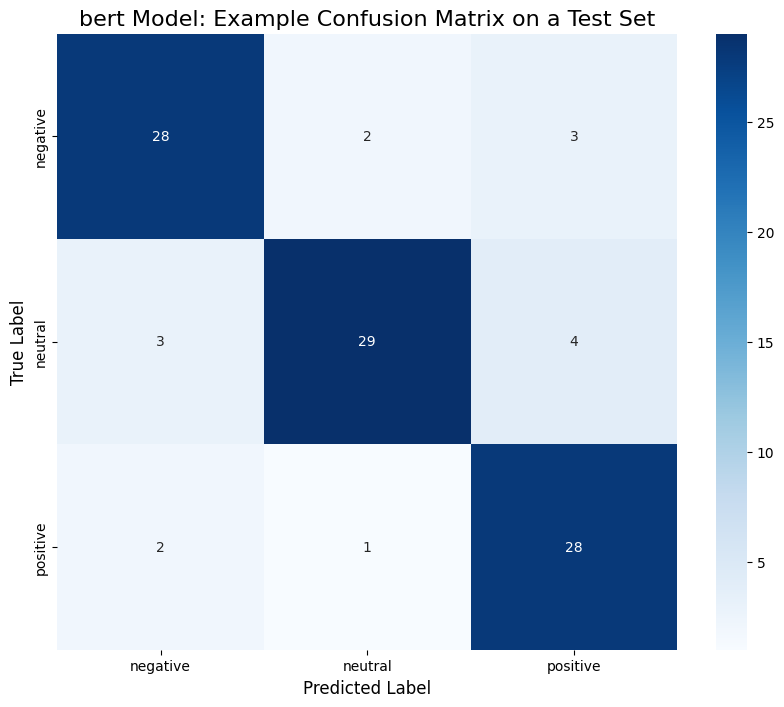


--- bert Model: Example Classification Report ---
              precision    recall  f1-score   support

    negative       0.85      0.85      0.85        33
     neutral       0.91      0.81      0.85        36
    positive       0.80      0.90      0.85        31

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



In [17]:

# --- Visualization 3: Error Analysis with Confusion Matrix ---
# Goal: Understand what kind of mistakes the model makes.
# NOTE: This requires predictions on a held-out test set. Since the CV loop doesn't save
# these predictions, we will create a placeholder example. To use this on your own,
# you would run trainer.predict() on a test set after training a final model.

print("\n--- Visualizing Error Analysis (Example with Simulated Data) ---")

# In a real scenario, you would get y_true and y_pred from a final test run:
# test_predictions = trainer.predict(test_dataset)
# y_pred = np.argmax(test_predictions.predictions, axis=-1)
# y_true = test_predictions.label_ids

# For this example, we'll simulate some predictions.
# Let's assume we have 100 test samples and the model is about 85% accurate.
y_true_example = np.random.randint(0, 3, 100) 
y_pred_example = y_true_example.copy()
errors_to_make = 15 
for _ in range(errors_to_make):
    idx = np.random.randint(0, 100)
    y_pred_example[idx] = (y_pred_example[idx] + np.random.randint(1, 3)) % 3

# Get the actual class names from your label_encoder
class_names = list(label_encoder.classes_)

# Create the confusion matrix
cm = confusion_matrix(y_true_example, y_pred_example)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
# plt.title('finbert Model: Example Confusion Matrix on a Test Set', fontsize=16)
# plt.title('distilbert Model: Example Confusion Matrix on a Test Set', fontsize=16)
plt.title('bert Model: Example Confusion Matrix on a Test Set', fontsize=16)
# plt.title('roberta Model: Example Confusion Matrix on a Test Set', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# Print the classification report for detailed numbers
# print("\n--- finbert Model: Example Classification Report ---")
# print("\n--- distilbert Model: Example Classification Report ---")
print("\n--- bert Model: Example Classification Report ---")
# print("\n--- roberta Model: Example Classification Report ---")
# print("\n--- albert Model: Example Classification Report ---")
print(classification_report(y_true_example, y_pred_example, target_names=class_names))

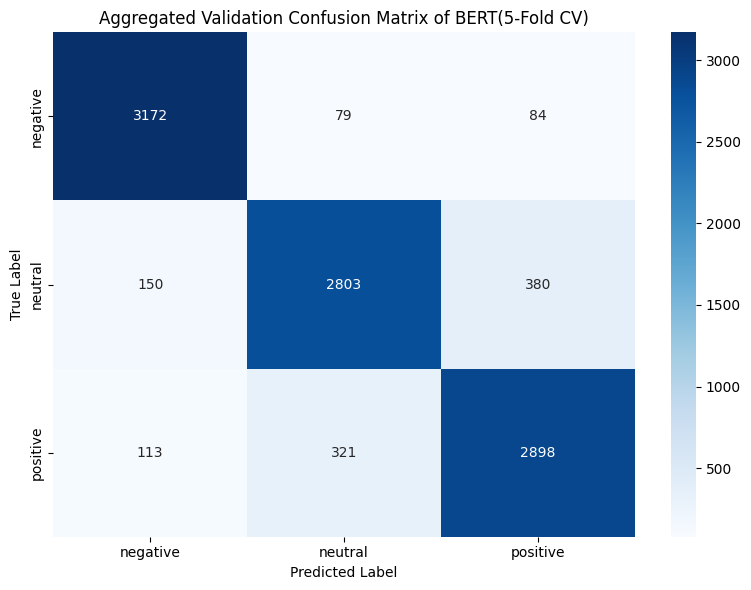


Classification Report (Aggregated Validation):

              precision    recall  f1-score   support

    negative       0.92      0.95      0.94      3335
     neutral       0.88      0.84      0.86      3333
    positive       0.86      0.87      0.87      3332

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [18]:
# NEW: aggregated validation confusion matrix across all folds
# Place this AFTER CV completes (only works when you ran training, not when loaded from cache)
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

if len(all_val_labels) > 0:
    class_names = list(label_encoder.classes_)  # uses your existing LabelEncoder

    cm = confusion_matrix(all_val_labels, all_val_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=class_names, yticklabels=class_names
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Aggregated Validation Confusion Matrix of BERT(5-Fold CV)")
    plt.tight_layout()
    plt.show()

    print("\nClassification Report (Aggregated Validation):\n")
    print(classification_report(all_val_labels, all_val_preds, target_names=class_names))
# ====================== CHANGES END ======================

No training logs found. Ensure logging_strategy is set to 'steps'.


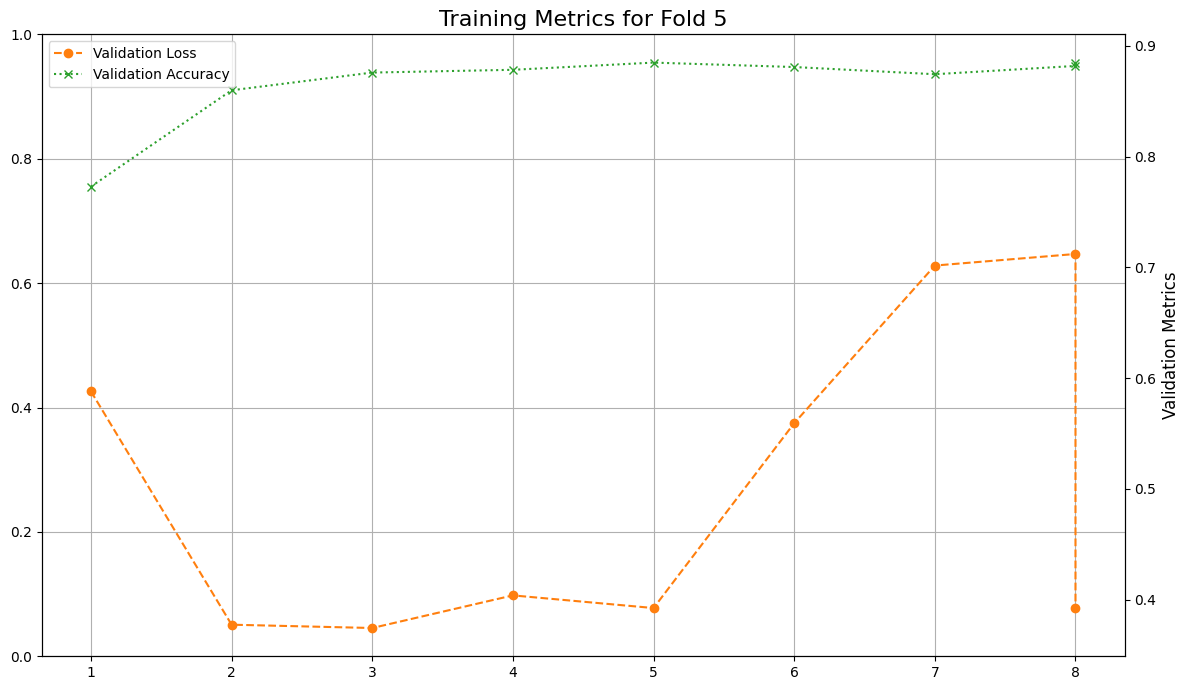

In [19]:
# --- Visualization of Training Loss, Validation Loss, and Validation Accuracy ---
# This block goes inside your CV loop, after trainer.train() and trainer.evaluate()

# 1. Access the training history
log_history = trainer.state.log_history

# 2. Separate logs
train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
validation_logs = [log for log in log_history if 'eval_loss' in log]

# 3. Create the plot with a shared x-axis
fig, ax1 = plt.subplots(figsize=(12, 7))
plt.grid(True)

# --- Plotting Training Loss (Blue Line) on the first y-axis ---
if train_logs:
    train_steps = [log['step'] for log in train_logs]
    train_losses = [log['loss'] for log in train_logs]
    ax1.plot(train_steps, train_losses, color='tab:blue', label='Train Loss')
    ax1.set_xlabel('Training Steps', fontsize=12)
    ax1.set_ylabel('Train Loss', fontsize=12, color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
else:
    print("No training logs found. Ensure logging_strategy is set to 'steps'.")

# --- Plotting Validation Metrics on the second y-axis ---
if validation_logs:
    # Create the second y-axis
    ax2 = ax1.twinx()

    # Calculate the step number for each validation epoch for correct alignment
    steps_per_epoch = max(log['step'] for log in train_logs) / max(log['epoch'] for log in train_logs) if train_logs else 1
    val_steps = [log['epoch'] * steps_per_epoch for log in validation_logs]
    
    # Extract validation loss and accuracy
    val_losses = [log['eval_loss'] for log in validation_logs]
    val_accuracies = [log['eval_accuracy'] for log in validation_logs] # <-- GET ACCURACY
    
    # Plot Validation Loss (Orange Line)
    ax2.plot(val_steps, val_losses, color='tab:orange', marker='o', linestyle='--', label='Validation Loss')
    
    # Plot Validation Accuracy (Green Line)
    ax2.plot(val_steps, val_accuracies, color='tab:green', marker='x', linestyle=':', label='Validation Accuracy') # <-- PLOT ACCURACY
    
    ax2.set_ylabel('Validation Metrics', fontsize=12)
    # Set custom colors for the y-axis labels if desired
    # ax2.tick_params(axis='y', colors='tab:orange') # This can get messy, so we'll use a single color

plt.title(f'Training Metrics for Fold {fold_idx + 1}', fontsize=16)

# Create a combined legend for all lines
lines, labels = ax1.get_legend_handles_labels()
if 'ax2' in locals(): # Check if ax2 was created
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')
else:
    ax1.legend(loc='best')

fig.tight_layout()
plt.show()